# Cyclistic membership prediction models comparison

## Introduction

This project is about a bike-share company called Cyclistic,whose marketing team needs to use digital marketing to encourage casual riders to become members.They need to know who are more likely to become members,so we are comparing the performances of different models,including logistic regression,decision trees and random forest.

## Data Description

The dataset comes from Google Data Analytics certificate course and for the purposes of a case study.The data has been made available by Motivate International Inc. under this
license(https://divvybikes.com/data-license-agreement).
For this project,the data is given for the whole 2023.

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
#Combine 12 monthly csv files into one dataframe

file_names=[r"C:\Users\syuan\OneDrive\바탕 화면\DA\cyclist_share_project\202301-divvy-tripdata.csv",
            r"C:\Users\syuan\OneDrive\바탕 화면\DA\cyclist_share_project\202302-divvy-tripdata.csv",
            r"C:\Users\syuan\OneDrive\바탕 화면\DA\cyclist_share_project\202303-divvy-tripdata.csv",
            r"C:\Users\syuan\OneDrive\바탕 화면\DA\cyclist_share_project\202304-divvy-tripdata.csv",
            r"C:\Users\syuan\OneDrive\바탕 화면\DA\cyclist_share_project\202305-divvy-tripdata.csv",
            r"C:\Users\syuan\OneDrive\바탕 화면\DA\cyclist_share_project\202306-divvy-tripdata.csv",
            r"C:\Users\syuan\OneDrive\바탕 화면\DA\cyclist_share_project\202307-divvy-tripdata.csv",
            r"C:\Users\syuan\OneDrive\바탕 화면\DA\cyclist_share_project\202308-divvy-tripdata.csv",
            r"C:\Users\syuan\OneDrive\바탕 화면\DA\cyclist_share_project\202309-divvy-tripdata.csv",
            r"C:\Users\syuan\OneDrive\바탕 화면\DA\cyclist_share_project\202310-divvy-tripdata.csv",
            r"C:\Users\syuan\OneDrive\바탕 화면\DA\cyclist_share_project\202311-divvy-tripdata.csv",
            r"C:\Users\syuan\OneDrive\바탕 화면\DA\cyclist_share_project\202312-divvy-tripdata.csv"]
dfs = []
for file in file_names:
    df = pd.read_csv(file)
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

In [3]:
combined_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,F96D5A74A3E41399,electric_bike,2023-01-21 20:05:42,2023-01-21 20:16:33,Lincoln Ave & Fullerton Ave,TA1309000058,Hampden Ct & Diversey Ave,202480.0,41.924074,-87.646278,41.930000,-87.640000,member
1,13CB7EB698CEDB88,classic_bike,2023-01-10 15:37:36,2023-01-10 15:46:05,Kimbark Ave & 53rd St,TA1309000037,Greenwood Ave & 47th St,TA1308000002,41.799568,-87.594747,41.809835,-87.599383,member
2,BD88A2E670661CE5,electric_bike,2023-01-02 07:51:57,2023-01-02 08:05:11,Western Ave & Lunt Ave,RP-005,Valli Produce - Evanston Plaza,599,42.008571,-87.690483,42.039742,-87.699413,casual
3,C90792D034FED968,classic_bike,2023-01-22 10:52:58,2023-01-22 11:01:44,Kimbark Ave & 53rd St,TA1309000037,Greenwood Ave & 47th St,TA1308000002,41.799568,-87.594747,41.809835,-87.599383,member
4,3397017529188E8A,classic_bike,2023-01-12 13:58:01,2023-01-12 14:13:20,Kimbark Ave & 53rd St,TA1309000037,Greenwood Ave & 47th St,TA1308000002,41.799568,-87.594747,41.809835,-87.599383,member


In [4]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5719877 entries, 0 to 5719876
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 567.3+ MB


In [5]:
#Check if there are nulls
combined_df.isnull().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    875716
start_station_id      875848
end_station_name      929202
end_station_id        929343
start_lat                  0
start_lng                  0
end_lat                 6990
end_lng                 6990
member_casual              0
dtype: int64

In [6]:
combined_df.dropna(inplace=True)

In [7]:
#Check if there are duplicates
combined_df.duplicated().sum()

0

In [8]:
#Convert 'started_at' and 'ended_at' columns to datetime
combined_df['started_at'] = pd.to_datetime(combined_df['started_at'])
combined_df['ended_at'] = pd.to_datetime(combined_df['ended_at'])


In [9]:
#Calculate 'ride_time'
combined_df['ride_time']=(combined_df['ended_at']-combined_df['started_at']).dt.total_seconds()/60

In [10]:
#Check if there are outliers
avg_time_difference=combined_df['ride_time'].mean()
print("avg_ride_time:",avg_time_difference)

max_time_difference=combined_df['ride_time'].max()
print("max_ride_time:",max_time_difference)

min_time_difference=combined_df['ride_time'].min()
print("min_difference:",min_time_difference)

avg_ride_time: 15.951847989718605
max_ride_time: 12136.3
min_difference: -54.56666666666667


In [11]:
#Remove outliers
Q1=combined_df['ride_time'].quantile(0.25)
Q3=combined_df['ride_time'].quantile(0.75)
IQR=Q3-Q1

upper_limit=Q3+1.5*IQR
lower_limit=Q1-1.5*IQR

outliers=combined_df[(combined_df['ride_time']<lower_limit)|(combined_df['ride_time']>upper_limit)]
combined_df=combined_df.drop(outliers.index)

In [12]:
avg_time_difference=combined_df['ride_time'].mean()
print("avg_ride_time:",avg_time_difference)

max_time_difference=combined_df['ride_time'].max()
print("max_ride_time:",max_time_difference)

min_time_difference=combined_df['ride_time'].min()
print("min_difference:",min_time_difference)

avg_ride_time: 11.099252043916263
max_ride_time: 35.28333333333333
min_difference: -11.6


In [13]:
#The minimum difference is still negative,which doesn't make sense.Any ride_time shorter than 0 should be removed.
negative_ride_time=combined_df[(combined_df['ride_time']<0)]
combined_df=combined_df.drop(negative_ride_time.index)

In [14]:
avg_time_difference=combined_df['ride_time'].mean()
print("avg_ride_time:",avg_time_difference)

max_time_difference=combined_df['ride_time'].max()
print("max_ride_time:",max_time_difference)

min_time_difference=combined_df['ride_time'].min()
print("min_difference:",min_time_difference)

avg_ride_time: 11.09935329848536
max_ride_time: 35.28333333333333
min_difference: 0.0


In [15]:
#Find out the days of the rides
combined_df['ride_day']=combined_df['started_at'].dt.day_name()

In [16]:
#Find out the number of members and casual riders
num=combined_df.groupby('member_casual')['ride_id'].size().reset_index(name='count')
num

,member_casual,count
0,casual,1304663
1,member,2699013


In [17]:
#Find out what time in a day bikes are mostly used
combined_df['start_time']=combined_df['started_at'].dt.hour
combined_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_time,ride_day,start_time
0,F96D5A74A3E41399,electric_bike,2023-01-21 20:05:42,2023-01-21 20:16:33,Lincoln Ave & Fullerton Ave,TA1309000058,Hampden Ct & Diversey Ave,202480.0,41.924074,-87.646278,41.930000,-87.640000,member,10.850000,Saturday,20
1,13CB7EB698CEDB88,classic_bike,2023-01-10 15:37:36,2023-01-10 15:46:05,Kimbark Ave & 53rd St,TA1309000037,Greenwood Ave & 47th St,TA1308000002,41.799568,-87.594747,41.809835,-87.599383,member,8.483333,Tuesday,15
2,BD88A2E670661CE5,electric_bike,2023-01-02 07:51:57,2023-01-02 08:05:11,Western Ave & Lunt Ave,RP-005,Valli Produce - Evanston Plaza,599,42.008571,-87.690483,42.039742,-87.699413,casual,13.233333,Monday,7
3,C90792D034FED968,classic_bike,2023-01-22 10:52:58,2023-01-22 11:01:44,Kimbark Ave & 53rd St,TA1309000037,Greenwood Ave & 47th St,TA1308000002,41.799568,-87.594747,41.809835,-87.599383,member,8.766667,Sunday,10
4,3397017529188E8A,classic_bike,2023-01-12 13:58:01,2023-01-12 14:13:20,Kimbark Ave & 53rd St,TA1309000037,Greenwood Ave & 47th St,TA1308000002,41.799568,-87.594747,41.809835,-87.599383,member,15.316667,Thursday,13


In [18]:
#Find out in what month bikes are mostly used
combined_df['start_month']=combined_df['started_at'].dt.month
combined_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_time,ride_day,start_time,start_month
0,F96D5A74A3E41399,electric_bike,2023-01-21 20:05:42,2023-01-21 20:16:33,Lincoln Ave & Fullerton Ave,TA1309000058,Hampden Ct & Diversey Ave,202480.0,41.924074,-87.646278,41.930000,-87.640000,member,10.850000,Saturday,20,1
1,13CB7EB698CEDB88,classic_bike,2023-01-10 15:37:36,2023-01-10 15:46:05,Kimbark Ave & 53rd St,TA1309000037,Greenwood Ave & 47th St,TA1308000002,41.799568,-87.594747,41.809835,-87.599383,member,8.483333,Tuesday,15,1
2,BD88A2E670661CE5,electric_bike,2023-01-02 07:51:57,2023-01-02 08:05:11,Western Ave & Lunt Ave,RP-005,Valli Produce - Evanston Plaza,599,42.008571,-87.690483,42.039742,-87.699413,casual,13.233333,Monday,7,1
3,C90792D034FED968,classic_bike,2023-01-22 10:52:58,2023-01-22 11:01:44,Kimbark Ave & 53rd St,TA1309000037,Greenwood Ave & 47th St,TA1308000002,41.799568,-87.594747,41.809835,-87.599383,member,8.766667,Sunday,10,1
4,3397017529188E8A,classic_bike,2023-01-12 13:58:01,2023-01-12 14:13:20,Kimbark Ave & 53rd St,TA1309000037,Greenwood Ave & 47th St,TA1308000002,41.799568,-87.594747,41.809835,-87.599383,member,15.316667,Thursday,13,1


In [19]:
selected_columns=['member_casual','ride_time','ride_day','start_time','start_month']
df_copy=combined_df[selected_columns].copy()
df_copy['member_casual']=df_copy['member_casual'].map({'member': 1, 'casual': 0})
df_copy['ride_day']=df_copy['ride_day'].map({'Sunday': 0, 'Monday': 1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6})

In [20]:
df_copy

,member_casual,ride_time,ride_day,start_time,start_month
0,1,10.850000,6,20,1
1,1,8.483333,2,15,1
2,0,13.233333,1,7,1
3,1,8.766667,0,10,1
4,1,15.316667,4,13,1
...,...,...,...,...,...
5719872,0,2.216667,4,13,12
5719873,0,3.583333,5,18,12
5719874,1,3.833333,2,14,12
5719875,0,17.633333,6,21,12


In [21]:
df_copy['member_casual'].value_counts(normalize=True)

member_casual
1    0.674134
0    0.325866
Name: proportion, dtype: float64

In [22]:
#Since 'casual' feature only had 33% riders out of total riders, this make our 'Churn' feature imbalance. 
#In this case, I will apply oversampling method to balance the dataset.
data_majority=df_copy[df_copy['member_casual']==1]
data_minority=df_copy[df_copy['member_casual']==0]

data_minority_upsampled=resample(data_minority,replace=True,n_samples=len(data_majority),random_state=0)

data_upsampled=pd.concat([data_majority,data_minority_upsampled]).reset_index(drop=True)

In [23]:
data_upsampled['member_casual'].value_counts()

member_casual
1    2699013
0    2699013
Name: count, dtype: int64

In [24]:
#Check if there is severe multicollinearity among the features.

data_upsampled.corr(numeric_only=True)

,member_casual,ride_time,ride_day,start_time,start_month
member_casual,1.000000,-0.158319,-0.034373,-0.058584,-0.019710
ride_time,-0.158319,1.000000,0.017084,0.063267,0.019284
ride_day,-0.034373,0.017084,1.000000,0.034515,0.012184
start_time,-0.058584,0.063267,0.034515,1.000000,-0.004084
start_month,-0.019710,0.019284,0.012184,-0.004084,1.000000


In [25]:
# Select outcome variable
y=data_upsampled['member_casual']

In [26]:
#Select features
X = data_upsampled[['ride_time','ride_day','start_time','start_month']]

In [27]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=0)

In [28]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4048519, 4), (1349507, 4), (4048519,), (1349507,))

In [29]:
# Construct a logistic regression model and fit it to the training set

log_clf = LogisticRegression(random_state=0, max_iter=800).fit(X_train,y_train)

In [30]:
# Use the logistic regression model to get predictions on the testing set
y_pred = log_clf.predict(X_test)

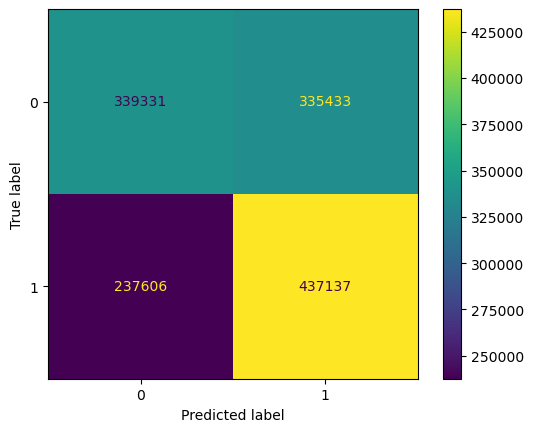

In [31]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm,display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

In [32]:
#Find out the logistic regrssion model metrics
target_labels = ['member', 'casual']
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")
print(classification_report(y_test, y_pred, target_names=target_labels))

Model Accuracy: 0.5753715986652903
              precision    recall  f1-score   support

      member       0.59      0.50      0.54    674764
      casual       0.57      0.65      0.60    674743

    accuracy                           0.58   1349507
   macro avg       0.58      0.58      0.57   1349507
weighted avg       0.58      0.58      0.57   1349507



In [33]:
#Build a decision trees model and fing out its metrics
clf = DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
target_labels = ['member', 'casual']

print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred, target_names=target_labels))

Accuracy: 0.6945617918247182
              precision    recall  f1-score   support

      member       0.66      0.81      0.73    674764
      casual       0.75      0.58      0.66    674743

    accuracy                           0.69   1349507
   macro avg       0.70      0.69      0.69   1349507
weighted avg       0.70      0.69      0.69   1349507



In [35]:
#Build a random forest model and fing out its metrics
model =RandomForestClassifier(n_estimators=50,random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
target_labels = ['member', 'casual']

print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred, target_names=target_labels))

Accuracy: 0.6898319163961357
              precision    recall  f1-score   support

      member       0.67      0.75      0.71    674764
      casual       0.72      0.63      0.67    674743

    accuracy                           0.69   1349507
   macro avg       0.69      0.69      0.69   1349507
weighted avg       0.69      0.69      0.69   1349507



In [46]:
model =RandomForestClassifier(n_estimators=100,n_jobs=-1,random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
target_labels = ['member', 'casual']

print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred, target_names=target_labels))

Accuracy: 0.6899556652911026
              precision    recall  f1-score   support

      member       0.67      0.75      0.71    674764
      casual       0.72      0.63      0.67    674743

    accuracy                           0.69   1349507
   macro avg       0.69      0.69      0.69   1349507
weighted avg       0.69      0.69      0.69   1349507



### Conclusion

We tried using logistic regression,decision trees and random forest models to predict whether a rider would become a member based on how long and when they ride.Since missing a casual rider has greater consequences,not only is accuracy important, recall is worth paying attention to as well.In this case,decision trees model has the highest accuracy and recall(about 69%),which translates into decent predictive power.